In [1]:
!pip install pandas scikit-learn xgboost
!pip install boostaroota

In [2]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

In [4]:
# Load Dataset

file_path = "/Users/Sebastiano/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
print(df)

N° of patients: 47
N° of columns: 932
        Patient  Gender  Age  NP-SLE                            Event  \
0    Paziente 1       0   38       1  Mood abnormalities (depressive)   
1    Paziente 2       0   41       0                              Na    
2    job1625735       0   58       2                              Na    
3    Paziente 3       0   32       0                              Na    
4    job1625738       0   42       2                              Na    
5    Paziente 4       0   31       1                          Seizure   
6    Paziente 5       0   43       0                              Na    
7    job1625736       0   44       2                              Na    
8    job1625737       0   45       2                              Na    
9    Paziente 6       0   55       0                              Na    
10   job1625734       0   52       2                              Na    
11   Paziente 7       0   44       0                              Na    
12   Paziente

In [5]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [6]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [13]:
# Define your features and target variable
X = df.drop(['NP-SLE'], axis=1) 
y = df['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['SLE', 'NPSLE', 'Control'])

# Print the results
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.7
Classification Report:
               precision    recall  f1-score   support

         SLE       0.50      0.50      0.50         2
       NPSLE       0.33      0.50      0.40         2
     Control       1.00      0.83      0.91         6

    accuracy                           0.70        10
   macro avg       0.61      0.61      0.60        10
weighted avg       0.77      0.70      0.73        10



In [15]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3, missing=1, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


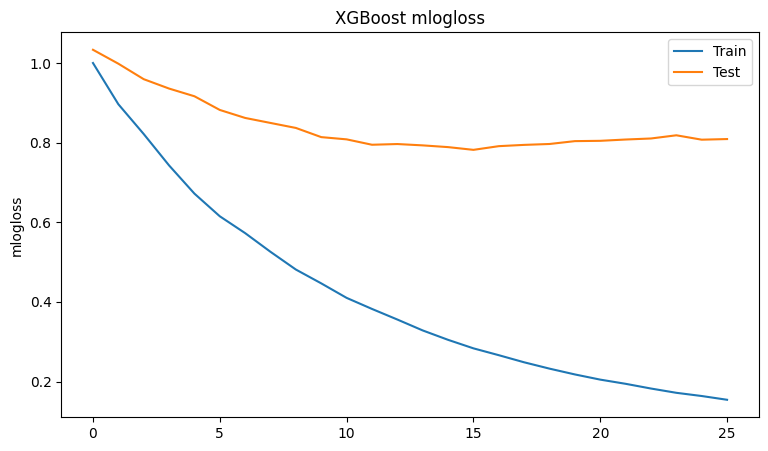

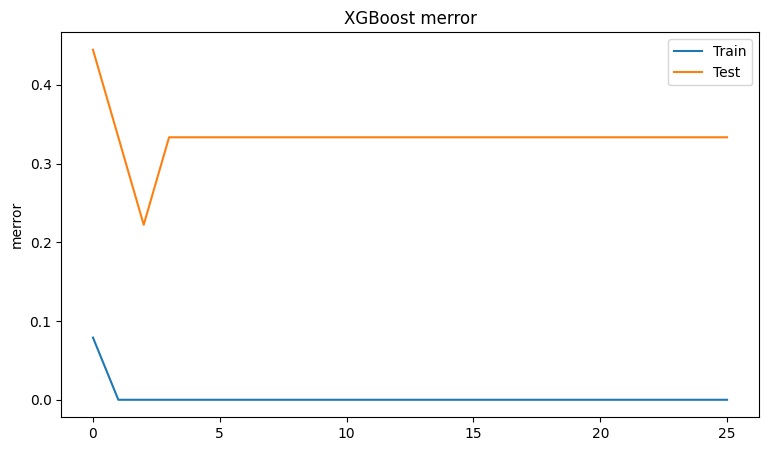


------------------ Confusion Matrix -----------------

[[1 1 1]
 [0 1 1]
 [0 0 4]]

Accuracy: 0.67
Balanced Accuracy: 0.61

Micro Precision: 0.67
Micro Recall: 0.67
Micro F1-score: 0.67

Macro Precision: 0.72
Macro Recall: 0.61
Macro F1-score: 0.60

Weighted Precision: 0.74
Weighted Recall: 0.67
Weighted F1-score: 0.63

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      0.50      0.50         2
           2       0.67      1.00      0.80         4

    accuracy                           0.67         9
   macro avg       0.72      0.61      0.60         9
weighted avg       0.74      0.67      0.63         9

---------------------- XGBoost ----------------------


In [18]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define the hyperparameters for the XGBoost classifier
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'missing': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'reg_lambda': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 10,
    'eval_metric': ['merror', 'mlogloss'],
    'seed': 42
}

# Define the best hyperparameters
best_hyperparameters = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 200,
    'subsample': 0.8
}

# Update the xgb_params dictionary with the best hyperparameters
xgb_params.update(best_hyperparameters)

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store the results
validation_results = {'train': {'mlogloss': [], 'merror': []}, 'test': {'mlogloss': [], 'merror': []}}

# Perform Stratified K-Fold Cross Validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the XGBoost classifier with the best hyperparameters
    xgb_clf = xgb.XGBClassifier(**xgb_params)
    xgb_clf.fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

    # Retrieve results for plotting
    results = xgb_clf.evals_result()
    for i, key in enumerate(['validation_0', 'validation_1']):
        for metric in ['mlogloss', 'merror']:
            validation_results['train' if i == 0 else 'test'][metric].append(results[key][metric][-1])

# Compute average results over folds
average_results = {key: {metric: np.mean(validation_results[key][metric]) for metric in validation_results[key]} for key in validation_results}

# Prepare evaluation metric plots
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot mlogloss
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

# Plot merror
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror')
plt.show()

# Get predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Print confusion matrix and evaluation metrics
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------')
